In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes
from pathlib import Path

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

In [2]:
import src.loadProcessed as loadp

counts: pd.DataFrame = loadp.load_processed_count()
locations: pd.DataFrame = loadp.load_processed_locations()

I want to make sure we have a reasonable amount of data before covid (2019) and after covid (2022) in each set. I will also need to try and account for zeros in the data if there is a significant amount.

In [3]:
# Make sets of just the sensors with readings in 2019 or 2022
sensors_2019 = set(counts[counts['sensing_date'].dt.year == 2019]['sensor_id'].unique())
sensors_2022 = set(counts[counts['sensing_date'].dt.year == 2022]['sensor_id'].unique())

# Take the intersection of those sets
common_sensors = sensors_2019 & sensors_2022

# Filter to only those sensors
counts_with_common_dates = counts[counts['sensor_id'].isin(common_sensors)]

# Limit to only 2019 and 2022
limited_counts: pd.DataFrame = counts_with_common_dates[counts_with_common_dates['sensing_date'].dt.year.isin([2019, 2022])]

Text(0.5, 0, 'Date')

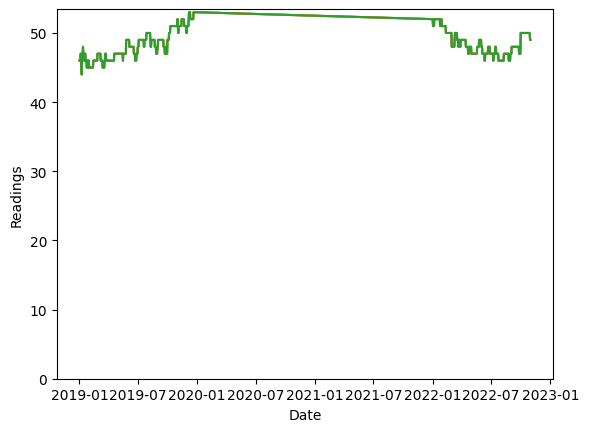

In [4]:
fig, ax = plt.subplots()

ax.plot(limited_counts.groupby('sensing_date').count())
ax.set_ylim(0)
ax.set_ylabel('Readings')
ax.set_xlabel('Date')

Above is a bit of a janky plot of the number of readings we have on each day (so the number of active sensors). We can see the count is pretty similar in 2019 and 2022 which is good, there is however a slighly worying amount of noise as these gaps may prove hard to deal with.

In [5]:
zero_rows = limited_counts[limited_counts['daily_count'] == 0]
zero_sensors = zero_rows['sensor_id'].unique()
print(f'There are {len(zero_sensors)} sensors which recorded at least one day with zero readings in the timeframe')

There are 8 sensors which recorded at least one day with zero readings in the timeframe


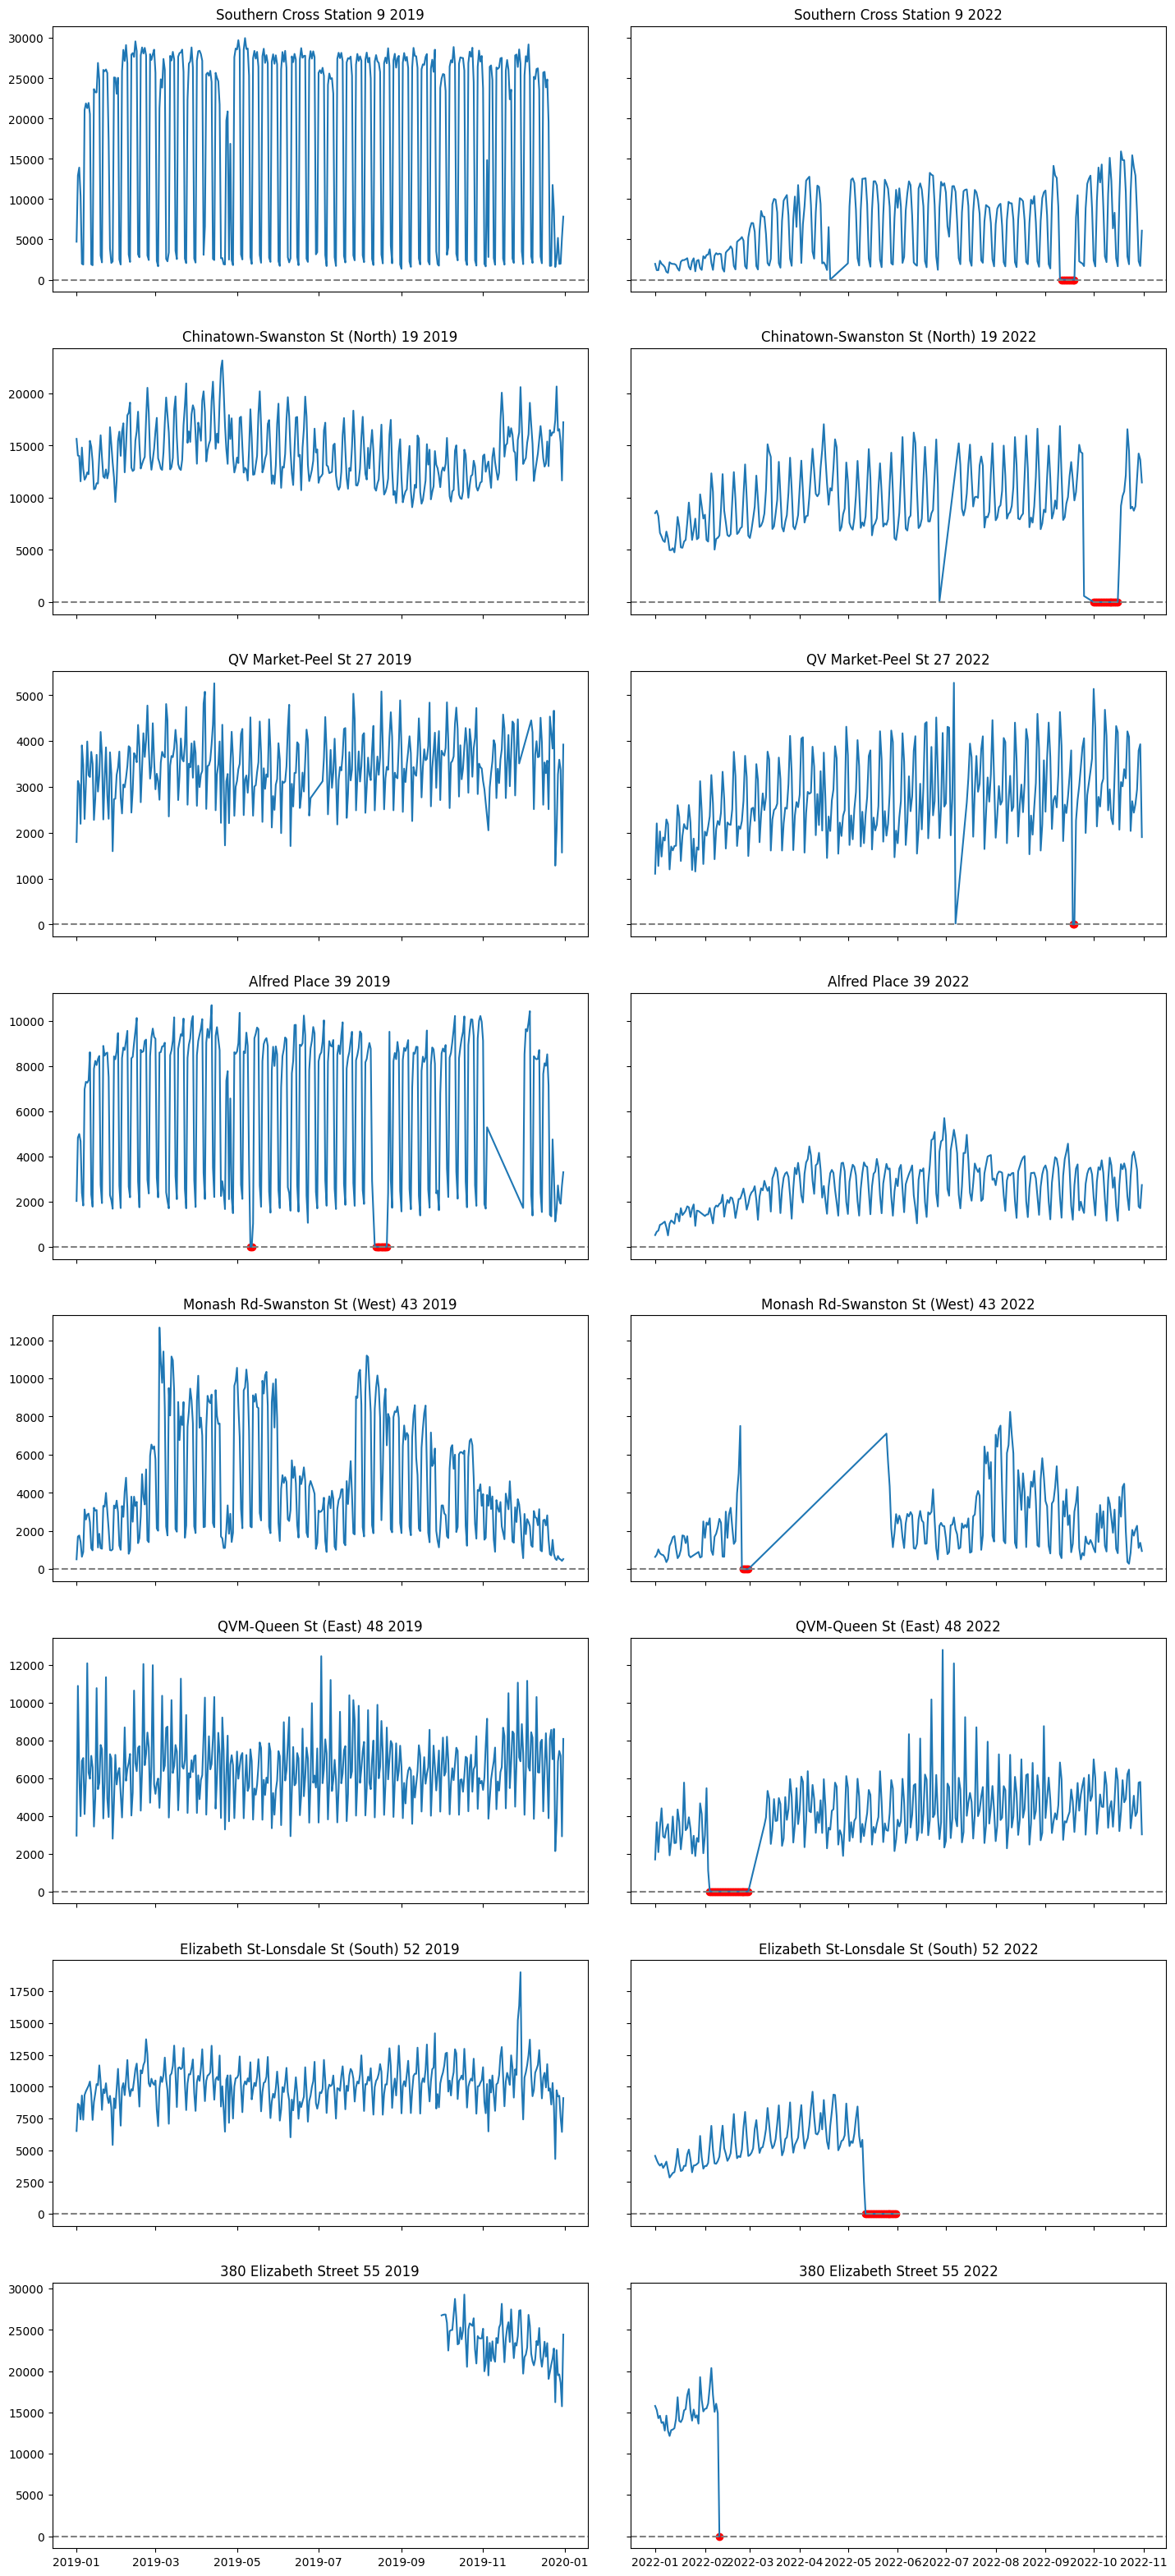

In [6]:
fig, axs = plt.subplots(len(zero_sensors), 2, figsize=(15, len(zero_sensors) * 4), sharex='col', sharey='row')

for i, sensor_id in enumerate(zero_sensors):
    location = locations[locations['sensor_id'] == sensor_id]

    ax_2019, ax_2022 = axs[i]

    ax_2019.set_title(f'{location['sensor_description'].item()} {location['sensor_id'].item()} 2019')
    ax_2022.set_title(f'{location['sensor_description'].item()} {location['sensor_id'].item()} 2022')

    data_2019 = limited_counts[(limited_counts['sensor_id'] == sensor_id) & (limited_counts['sensing_date'].dt.year == 2019)]
    data_2022 = limited_counts[(limited_counts['sensor_id'] == sensor_id) & (limited_counts['sensing_date'].dt.year == 2022)]
    
    ax_2019.plot(data_2019['sensing_date'], data_2019['daily_count'])
    ax_2022.plot(data_2022['sensing_date'], data_2022['daily_count'])

    ax_2019.axhline(color='gray', linestyle='--')
    ax_2022.axhline(color='gray', linestyle='--')

    ax_2019.scatter(data_2019[data_2019['daily_count'] <= 5]['sensing_date'], data_2019[data_2019['daily_count'] == 0]['daily_count'], color='red')
    ax_2022.scatter(data_2022[data_2022['daily_count'] <= 5]['sensing_date'], data_2022[data_2022['daily_count'] == 0]['daily_count'], color='red')

fig.tight_layout(pad=3.0)

Upon analysing these zero points, it seems that these are anomalies that should not be considered in our analysis. They seem to be errors in the recording, perhaps due to power outage, system malfunction or being obstructed. Regardless, I believe it is reasonable to remove these data points.

In [7]:
limited_counts = limited_counts[limited_counts['daily_count'] > 0]